In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, style='whitegrid')

## Brainstorming
- Bigger weights for `amount_borrowed`, `borrowed_in_months`, `n_bankruptcies`
- Filling NaN of `ok_since` with 0? Expect the worst?
- Clip income due to outliers


## Reading the data

In [78]:
df_train = pd.read_csv('puzzle_train_dataset.csv')

## Remove clients that do not have the target variable

In [233]:
df_train.dropna(axis=0, subset=['default'], inplace=True)
df_train['default'] = df_train['default'].astype(bool)
feature_columns = df_train.columns.drop(['ids', 'default'])

In [80]:
df_train.dtypes

ids                    object
default                  bool
score_1                object
score_2                object
score_3               float64
score_4               float64
score_5               float64
score_6               float64
risk_rate             float64
amount_borrowed       float64
borrowed_in_months    float64
credit_limit          float64
reason                 object
income                float64
sign                   object
gender                 object
facebook_profile       object
state                  object
zip                    object
channel                object
job_name               object
real_state             object
ok_since              float64
n_bankruptcies        float64
n_defaulted_loans     float64
n_accounts            float64
n_issues              float64
dtype: object

## Describing the categorical columns
- The column `sign` has a lot of missing data, so I decided to drop it. I also wonder if it would be useful at all for default prediction...
- The column `channel` is equal to all the clients, so I dropped it.
- The column `facebook_profile` has around 10% of missing data. **Is it useful?**
- The column `reason` has only 5 missing values out of 59966. Because of the small amount, I decided to ~~drop these 5 clients as a person should not be able to ask for a loan without a known reason.~~ fill in with the most frequent.
- I believe that the feature `job_name`, due to its huge amount of unique values, is very granular and, for the sake of default prediction, the client's income would carry as much information as the job name, if not more. So I decided not to use it.

# Replace less commom `reason` with others and `real_state`/`state` with probabilities of default

In [234]:
df_train['reason'].value_counts()

mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIXuusuYraWV4rGB3v/7WqHKeKq5W600DOWmwjMTqsrAW    5921
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIXuusuYraWV4rGB3v/7WqHIRsMoD5e3RXcnWOgQJkT1p    4091
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIW76/BS2rZFHqQxXY+8F9NKu9aZ57vT61+K2XFrHtvT9    2046
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiH9ooDQPWyPZgJWyjKkQUjr    1355
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIRd8GOItgxlRAUGKcWd5xXCeKq5W600DOWmwjMTqsrAW    1182
                                                                                                                                    ... 
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiEzAYeArD9c3QaMcoOOJr/t       1
mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaE

In [243]:
df_train.groupby('real_state')['default'].sum() / df_train['real_state'].value_counts()

+qWF9pJpVGtTFn4vFjb/cg==    0.083333
N5/CE7lSkAfB04hVFFwllw==    0.147235
UX7AdFYgQh+VrVC5eIaU9w==    0.245283
n+xK9CfX0bCn77lClTWviw==    0.171817
nSpvDsIsslUaX6GE6m6eQA==    0.158497
dtype: float64

In [247]:
df_train['state'].value_counts()["DLK5rpOxZhCM5oQvfUpkTQ=="]

2

In [249]:
df_train['state'].value_counts()["QCVqG0wT4xPLQuiTIExO2w=="]

725

In [245]:
(df_train.groupby('state')['default'].sum() / df_train['state'].value_counts()).sort_values(ascending=False)

DLK5rpOxZhCM5oQvfUpkTQ==    1.000000
GFOaXqGcKJxSSF9aBDDNaA==    0.333333
QCVqG0wT4xPLQuiTIExO2w==    0.200000
qItmSqWrjm+MopDA+UpKRw==    0.198291
OCoEDgPLpDjHcbEmPpAjvA==    0.186592
ZVfsutsd1Go0zZEnGp0vEA==    0.182004
rrVbgRNTRyB6auEycsRrpA==    0.181884
/78Q+NAqnsdbiE2JReYK9Q==    0.179439
fMOpZ7DFhwQgTxW547UMCQ==    0.178451
1DpYl6dtzY0qE33poow3iw==    0.175782
8ZKN5LHxobLWh6drCDlmhQ==    0.175342
x6Gw/1I8t3KPgT6s82Kodg==    0.174293
1vMmtGURgMcjxQbV2KQiUw==    0.173852
P1TKs1aii8osbgO+MszZ2w==    0.173469
BB/zpwTH+8GCIVHlhzOU1Q==    0.171734
0lQuvmygO68ZFXZjzHEOww==    0.171594
NX0S6z5x5fEStwXfBQN5FQ==    0.170370
0gQEZgRHqS5KSF3oWQrQfw==    0.169014
E8shyM/6btBNXXExsO17zw==    0.164609
7bX4XFXmYqoMspxup0CrKA==    0.163917
JrdZzPZEa/YIIGwh8OdTKA==    0.161259
ygE7OTdsxRMLeXMa0EZwZw==    0.160057
LXZkF0tV1Ma9JIlIvaUDiw==    0.159292
1xxlFOWSFxK0/J2VdCKP3g==    0.158235
82aTqSzrTImY+SbAOBQzGQ==    0.157328
bwNrC22VlFOFk6/nEHQc6A==    0.155556
/EoxQEzy1PWWTtv6DNwr2w==    0.153790
V

In [237]:
df_train['real_state'].value_counts()

N5/CE7lSkAfB04hVFFwllw==    29694
n+xK9CfX0bCn77lClTWviw==    25306
nSpvDsIsslUaX6GE6m6eQA==     4896
UX7AdFYgQh+VrVC5eIaU9w==       53
+qWF9pJpVGtTFn4vFjb/cg==       12
Name: real_state, dtype: int64

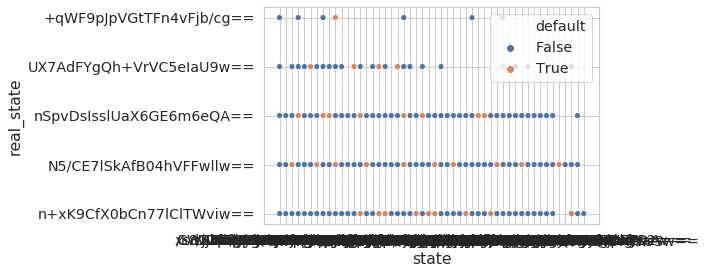

In [241]:
sns.scatterplot(x='state', y='real_state', data=df_train, hue='default')

In [238]:
df_train['state'].value_counts()

xsd3ZdsI3356I3xMxZeiqQ==    10212
BB/zpwTH+8GCIVHlhzOU1Q==     5328
sjJbkqJS7cXalHLBFA+EOQ==     4498
1DpYl6dtzY0qE33poow3iw==     4187
x6Gw/1I8t3KPgT6s82Kodg==     2404
kfFcVGcsJmH2n3eYprLkeQ==     2321
JrdZzPZEa/YIIGwh8OdTKA==     2065
GW2VZ3dN3OGHSjQ6JkfqQw==     1939
7bX4XFXmYqoMspxup0CrKA==     1879
82aTqSzrTImY+SbAOBQzGQ==     1856
0lQuvmygO68ZFXZjzHEOww==     1556
Ygq6MsM98oC8yceExr69Ig==     1519
1vMmtGURgMcjxQbV2KQiUw==     1415
rrVbgRNTRyB6auEycsRrpA==     1391
fR2lwAMjCb/fNXjsApiOTw==     1391
/EoxQEzy1PWWTtv6DNwr2w==     1372
bNDXnbe7XAx/VUe+cbjDiw==     1244
VafbDA6D5W2TpGMAUJbW8Q==      998
5hPtRY8gW/3+fPXvGIgWTg==      985
1xxlFOWSFxK0/J2VdCKP3g==      929
OCoEDgPLpDjHcbEmPpAjvA==      895
/L8vvVesB5WyAv190Hw/rQ==      790
QCVqG0wT4xPLQuiTIExO2w==      725
ygE7OTdsxRMLeXMa0EZwZw==      706
ZUmHOp1/xBWh5O/uqDutsw==      674
KET/Pmr6rHp1RJ/P9ymztw==      652
qItmSqWrjm+MopDA+UpKRw==      585
orU7WJYGPT/xFwOXY1eBkw==      536
/78Q+NAqnsdbiE2JReYK9Q==      535
P1TKs1aii8osbg

In [81]:
categorical_columns = df_train.select_dtypes('object').columns
describe_df = df_train[categorical_columns].describe().T
describe_df['missing_rate'] = (len(df_train) - describe_df['count']) / len(df_train)
describe_df

,count,unique,top,freq,missing_rate
ids,59966,59966,b662e2fa-c952-24c0-6cad-77521d2f980b,1,0
score_1,59966,7,DGCQep2AE5QRkNCshIAlFQ==,20484,0
score_2,59966,35,osCzpM4hJrxugqWWuZmMWw==,5058,0
reason,59961,19496,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,5921,8.33806e-05
sign,41028,12,libr,5582,0.315812
gender,56970,2,m,38497,0.0499616
facebook_profile,53995,2,False,33997,0.0995731
state,59966,50,xsd3ZdsI3356I3xMxZeiqQ==,10212,0
zip,59966,830,3k2JCQ8Bp5oDwaI39ZJgHA==,775,0
channel,59966,1,NCqL3QBx0pscDnx3ixKwXg==,59966,0


In [82]:
feature_columns.drop(['sign', 'channel', 'job_name'], inplace=True)
df_train.dropna(subset=['reason'], inplace=True)

## Describing the numerical columns
- The column `ok_since` has a missing rate bigger than 58%, so I decided to remove it.
- By analysing the missing data in the columns `n_bankruptcies`, `n_defaulted_loans` and `n_issues`, I noticed that they are missing only for clients with missing data in `credit_limit`. Among the clients without the `credit_limit` information, the values of `n_defaulted_loans` are only NaN and 0, so I decided it to fill it with zeros; regarding the values of `n_bankruptcies`, it is zero for more than 95% of the clients withou credit limit, so I filled it with zeros as well.
- I strongly believe that the feature `n_issues` is an engineered feature of Nubank clients, such as the amount of complainings via chat or amount of disputed charges on his/her credit card. Because of this reason, I decided not to use it, considering fresh clients that request a loan.
- In addition, due to the high amount of missing data in the `credit_limit` column, I decided to not use it. A nice test would be to the output of Nubank's credit limit regression model to fill in these gaps and see if it would improve the default prediction.
- The `income` column has an extremely high value, which is most likely an outlier. My decision was to clip the `income` column on 2000000.

In [83]:
numerical_columns = df_train.select_dtypes('number').columns
describe_df = df_train[numerical_columns].describe().T
describe_df['missing_rate'] = (len(df_train) - describe_df['count']) / len(df_train)
describe_df

,count,mean,std,min,25%,50%,75%,max,missing_rate
score_3,59961.0,346.445189,109.837696,0.000000,270.000000,340.000000,420.000000,9.900000e+02,0.000000
score_4,59961.0,100.000074,3.174444,86.191572,97.856673,100.008613,102.134871,1.139782e+02,0.000000
score_5,59961.0,0.498731,0.288656,0.000035,0.250020,0.497757,0.748464,9.999734e-01,0.000000
score_6,59961.0,99.943588,10.035382,60.663039,93.213265,99.980321,106.691810,1.424301e+02,0.000000
risk_rate,59961.0,0.294113,0.101179,0.000000,0.220000,0.290000,0.360000,9.000000e-01,0.000000
amount_borrowed,59961.0,13411.870380,7957.249776,527.070000,7225.980000,12012.420000,18036.650000,3.505960e+04,0.000000
borrowed_in_months,59961.0,40.674639,9.504766,36.000000,36.000000,36.000000,36.000000,6.000000e+01,0.000000
credit_limit,41185.0,34093.970548,36783.979537,0.000000,9907.000000,25338.000000,46762.000000,6.131170e+05,0.313137
income,59961.0,71327.286564,51692.973107,4821.180000,44027.910000,60047.400000,85039.670000,5.000028e+06,0.000000
ok_since,24877.0,35.276762,21.630884,0.000000,17.000000,32.000000,50.000000,1.410000e+02,0.585114


### Income boxplot

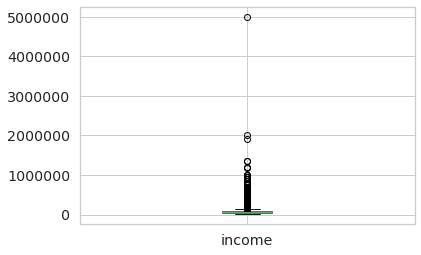

In [186]:
df_train['income'].plot(kind='box')

In [189]:
df_train['income'].clip(upper=2000000, inplace=True)

### Bankruptcies amont clients without `credit_limit`

In [84]:
df_train[df_train['credit_limit'].isna()]['n_bankruptcies'].unique()

array([ 0.,  1., nan,  2.])

In [85]:
df_train[df_train['credit_limit'].isna()]['n_bankruptcies'].value_counts() / len(df_train[df_train['credit_limit'].isna()])

0.0    0.954570
1.0    0.034459
2.0    0.000213
Name: n_bankruptcies, dtype: float64

### Amount of defaulted loans amont clients without `credit_limit`

In [86]:
df_train[df_train['credit_limit'].isna()]['n_defaulted_loans'].unique()

array([ 0., nan])

### Dropping the columns `credit_limit`, `ok_since` and `n_issues`

In [87]:
df_train.drop(['credit_limit', 'ok_since', 'n_issues'], axis=1, inplace=True)

### Filling `n_bankruptcies` and `n_defaulted_loans` with 0

In [88]:
df_train['n_bankruptcies'].fillna(0, inplace=True)
df_train['n_defaulted_loans'].fillna(0, inplace=True)

# Preparing the data for training

In [219]:
from fklearn.training.imputation import imputer, placeholder_imputer
from fklearn.training.transformation import capper, selector
my_zero_imputer = placeholder_imputer(columns_to_impute=['n_bankruptcies', 'n_defaulted_loans'])

In [218]:
df_train.columns.drop(['ids', 'default', 'facebook_profile'])

Index(['score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6',
       'risk_rate', 'amount_borrowed', 'borrowed_in_months', 'reason',
       'income', 'gender', 'state', 'zip', 'real_state', 'n_bankruptcies',
       'n_defaulted_loans', 'n_accounts'],
      dtype='object')

In [ ]:
feature_columns = df_train.columns  ['ids', 'default', 'facebook_profile']

df_train_rf = df_train.dropna()

categorical_columns = list(set(df_train_rf.select_dtypes('object').columns) - {'ids'})

# fklearn
A couple months back, I came across Nubank's library `fklearn`, but I have not stopped to try it out and read more about it. I decided this was the perfect opportunity to give it a try, and maybe even provide some feedback on it. I followed this [notebook](https://github.com/nubank/fklearn/blob/master/docs/source/examples/regression.ipynb) to get to know the basics.

### Splitting into train and test (holdout set)
Since this data does not have a temporal component, I randomly sampled 20% to be the holdout set. Fixed a seed just for reproducibility.

In [217]:
from sklearn.model_selection import train_test_split
SEED = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)

In [ ]:
from fklearn.training.transformation import standard_scaler


In [216]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, roc_curve, auc

In [191]:
# na_count = df_train.isna().sum()
# full_columns = na_count[na_count == 0].index
# df_train_rf = df_train[full_columns]

df_train_rf = df_train.dropna()

categorical_columns = list(set(df_train_rf.select_dtypes('object').columns) - {'ids'})

In [192]:
df_train_rf[categorical_columns] = df_train_rf[categorical_columns].astype('category')
df_train_rf[categorical_columns] = df_train_rf[categorical_columns].apply(lambda x: x.cat.codes)

/home/lucas/miniconda3/envs/nuenv/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [193]:
not_feat_columns = ['ids', 'default', 'facebook_profile']

In [194]:
X = df_train_rf[df_train_rf.columns.drop(not_feat_columns)]
y = df_train_rf['default'].astype(int)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [201]:
clf = RandomForestClassifier(max_depth=15, n_estimators=200, min_samples_split=0.05, class_weight='balanced', n_jobs=-1)

In [202]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=0.05, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [203]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [204]:
pd.DataFrame(classification_report(y_train, train_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.898594,0.273900,0.693242,0.586247,0.799825
recall,0.716487,0.569468,0.693242,0.642977,0.693242
f1-score,0.797274,0.369892,0.693242,0.583583,0.729701
support,34531.000000,6485.000000,0.693242,41016.000000,41016.000000


In [205]:
pd.DataFrame(classification_report(y_test, test_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.894767,0.266766,0.689292,0.580767,0.795490
recall,0.715047,0.552128,0.689292,0.633588,0.689292
f1-score,0.794875,0.359727,0.689292,0.577301,0.726085
support,8633.000000,1621.000000,0.689292,10254.000000,10254.000000


In [206]:
from sklearn.metrics import f1_score

In [207]:
f1_score(test_pred, y_test)

0.3597266881028939

In [208]:
pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

borrowed_in_months    0.344185
score_1               0.256093
income                0.119208
risk_rate             0.077765
score_2               0.048622
amount_borrowed       0.048326
gender                0.026502
score_3               0.017956
reason                0.011124
real_state            0.010831
score_4               0.008016
score_6               0.007750
score_5               0.006331
n_accounts            0.005937
zip                   0.005402
state                 0.004775
n_bankruptcies        0.001068
n_defaulted_loans     0.000110
dtype: float64

In [209]:
test_proba = clf.predict_proba(X_test)

In [214]:
fpr, tpr, thrs = roc_curve(y_test, test_proba[:,1])
roc_auc = auc(fpr, tpr)

In [215]:
thrs

array([1.74925705, 0.74925705, 0.74853862, ..., 0.24515925, 0.24511056,
       0.23674578])

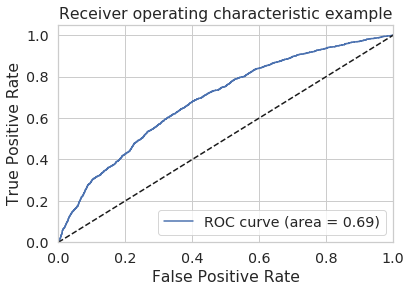

In [212]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Salary inequality

In [32]:
df_train['job_name_code'] = df_train['job_name'].astype('category').cat.codes
df_train['gender'] = df_train['gender'].astype('category')
df_train.groupby(['job_name_code', 'gender'])['income'].mean().dropna()

job_name_code  gender
-1             f         64976.946564
               m         64708.863399
 0             f                  NaN
               m         55037.340000
 1             f         24026.350000
                             ...     
 42260         m                  NaN
 42261         f                  NaN
               m         36014.580000
 42262         f                  NaN
               m         33026.120000
Name: income, Length: 84528, dtype: float64

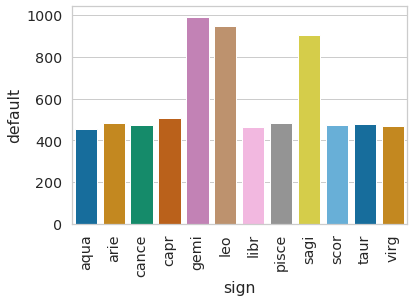

In [24]:
# ax = sns.barplot(x='sign', y='default', data=df_train.groupby('sign').sum()['default'].reset_index(), 
#                  palette='colorblind')
# text = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)